# **Técnicas Avanzadas de Aprendizaje**

## Actividad individual 3: "RECONOCIMIENTO DE NÚMEROS ESCRITOS A MANO"

Fabio Santamaría Iglesias

21/06/2021

Se importan las librerías básicas con las que trabajaremos:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# **Introducción**

El objetivo de esta entrega es crear un modelo tipo Random Forest para clasificar imágenes de dígitos numéricos del 0 al 9 escritos a mano. De esta forma, el algortimo aprenderá a leer imágenes con estas cifras y entender su valor. 


En resumen, un modelo Random Forest está constituido por un conjunto de diferentes árboles de decisión (AD) trabajando en paralelo:

![RF_wiki](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)

*Fuente: en.wikipedia.org*

1. Cuando llega una instancia, con K variables predictoras $X_0, X_1, ..., X_k$, se ejecuta su predicción en todos los AD al mismo tiempo.
2. Los AD son diferentes entre sí, bien porque los datos con los que se ha realizado el entrenamiento de cada uno no son los mismos (*Bootstrapping*), bien porque se hayan entrenado con variables distintas en cada ramificación (*Bagging*).
3. Los AD son de poca profundidad.
4. La predicción final se obtiene de agregar, de acuerdo a una regla dada, los diferentes resultados de todos los AD. En general, se calcula la media de las probabilidades que devuelve cada AD.



# **Lectura del dataset**

La base de datos MNIST (base de datos modificada del Instituto Nacional de Estándares y Tecnología) es una gran base de datos de dígitos escritos a mano que se usa, comúnmente, para entrenar varios sistemas de procesamiento de imágenes. La base de datos MNIST contiene 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba. Es posible acceder a esta base de datos a través de la librería *TensorFlow*:

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Disponemos de la siguiente información:

* *X_train*: array de 60.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de entrenamiento de 60.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 

* *Y_train*: array de 60.000 filas, donde cada fila tiene el valor entero del dígito de la imagen. 

* *X_test*: array de 10.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de test de 10.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 

* *Y_test*: array de 10.000 filas, donde cada fila tiene el valor entero del dígito de la imagen.

Para poder entrenar nuestro modelo, cambiamos la forma en la que está expresada la información, pasando todos los objetos 3D array a 2D array. De esta forma, las imágenes 28x28 quedan expresadas como filas de 784 columnas.

In [ ]:
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)

Se puede corroborar que efectivamente nuestra base de datos contiene dígitos del 0 al 9:

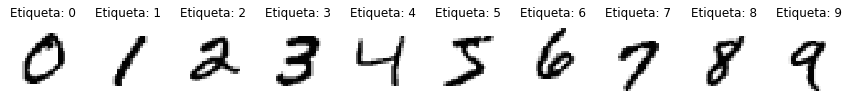

In [ ]:
u, indices = np.unique(y_train, return_index=True)
X_u = x_train[indices]
y_u = y_train[indices]

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Etiqueta: %i' % label)

Para la realización de esta tarea, creamos dos subconjuntos de entrenamiento, uno con 600 imágenes y otro con 6000. Esto nos permitirá evaluar cómo afecta el tamaño del dataset al comportamiento final.

In [ ]:
n_train = 600 # digitos a usar en entrenamiento
x_train_600 = x_train[0:n_train]
y_train_600 = y_train[0:n_train]

n_train = 6000 # digitos a usar en entrenamiento
x_train_6000 = x_train[0:n_train]
y_train_6000 = y_train[0:n_train]

Lo primero es comprobar cómo de balanceados están los *dataset* resultantes:

In [ ]:
pd.Series(y_train_600).value_counts() / len(y_train_600)

1    0.131667
9    0.108333
2    0.106667
7    0.103333
4    0.098333
3    0.098333
0    0.096667
6    0.090000
5    0.085000
8    0.081667
dtype: float64

In [ ]:
pd.Series(y_train_6000).value_counts() / len(y_train_6000)

1    0.111833
7    0.108500
4    0.103833
3    0.101333
6    0.101333
9    0.100167
0    0.098667
2    0.096833
8    0.091833
5    0.085667
dtype: float64

Se observa que el conjunto de 600 registros presenta mayor desproporcionalidad entre sus clases, habiendo un máximo del 13,1% de 1s y un mínimo de 8,1% de 8s. Por contra, en el conjunto de 6000 entradas el máximo se alcanza con 11,1% para los 1s y un 8,5% para los 5s.

A continuación, entrenaremos modelos sobre estos dos *dataset*, esperando obtener peores resultados para el conjunto más pequeño y desbalanceado.

# **Modelos con n = 600**

Contaremos con un conjunto de entrenamiento de 600 imágenes. El primer paso es crear diferentes modelos variando los parámetros n_estimators y max_depth. Estos controlan las características de los árboles de decisión empleados. Después, evaluaremos con diferentes métricas el mejor algoritmo encontrado sobre el conjunto total de imágenes test.




 



## Elección del modelo

Creamos diferentes algoritmos Random Forest cambiando los siguientes parámetros:

* **n_estimators**: número de árboles de decisión que componen el algoritmo Random Forest. Cuanto mayor es su número, más robusto es el modelo contra *overfitting* y más poder de computación es necesario. Por defecto su valor es 100.

* **max_depth**: profundidad de los árboles de decisión. Cuanto más alto es este número más se ajustan los AD al entrenamiento. Hemos visto que con AD muy poco profundos, Random Forest puede funcionar muy bien.

Primero variamos el *max_depth*:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,30,4)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=maxdepth, n_jobs=5)
  rf_model.fit(x_train_600, y_train_600)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(x_train_600, y_train_600))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

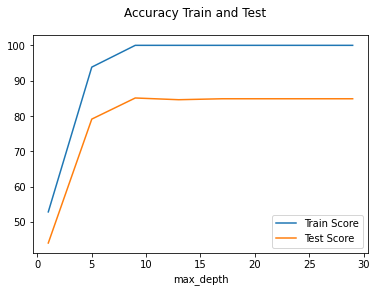

In [ ]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Como vemos, el resultado mejora hasta llegar a max_depth = 10, valor a partir del cual la *accuracy* tanto del conjunto de entrenamiento como del conjunto test se hace constante.

Por tanto, con valores inferiores a 10 construiríamos modelos con **underfitting**, demasiado sencillos para clasificar correctamente los datos. Un valor grande, añadiría complejidad innecesaria y consumiría recursos sin ofrecer a cambio un mejor resultado. Escogemos como valor óptimo max_depth = 10.

In [ ]:
rf_model_600_10 = RandomForestClassifier(max_depth=10, random_state=0, n_jobs=5)
rf_model_600_10.fit(x_train_600,y_train_600)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

A continuación, iteramos para diferentes números de árboles de decisión empleados:

In [ ]:
n_estimators_list = []
score_train_list = []
score_test_list = []

for n_estimators in list(range(10,200,10)):
  rf_model = RandomForestClassifier(random_state=0, n_estimators = n_estimators, max_depth=10, n_jobs=5)
  rf_model.fit(x_train_600, y_train_600)

  ## Generación de listas
  n_estimators_list.append(n_estimators)
  score_train_list.append(100.0*rf_model.score(x_train_600, y_train_600))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

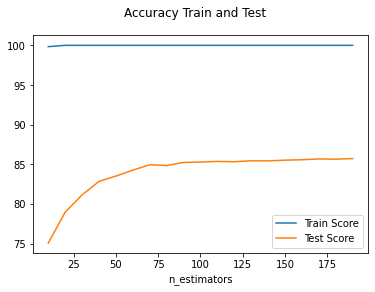

In [ ]:
df = pd.DataFrame({"n_estimators":n_estimators_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Para el conjunto de entrenamiento la *accuracy* se aproxima a 100 para cualquier valor del número de estimadores. Esto se debe fundamentalmente a que nuestros árboles son lo suficientemente profundos para clasificar muy bien el conjunto de entrenamiento.

Por su lado, en el dataset de prueba la *accuracy* va aumentando de forma monótona hasta alcanzar el 85% en 75 estimadores, valor a partir del cual la tendencia se vuelve prácticamente constante. De esta forma, conforme vamos aumentando el número de estimadores, nuestro algoritmo se va haciendo más resistente al **overfitting**.

Dado que la capacidad computacional requerida es directamente proporcional al número de estimadores, intentamos seleccionar el valor mínimo posible de forma que no afecte al rendimiento de nuestro modelo. Teniendo esto en cuenta, el óptimo se sitúa en 75 estimadores. 

## Modelo óptimo

Ya podemos crear el modelo que mejor se comporta en nuestro conjunto test teniendo en cuenta lo visto anteriormente. A continuación, aplicaremos las métricas correspondientes para analizar en profundidad su comportamiento.

In [ ]:
rf_model_600_final = RandomForestClassifier(max_depth=10, n_estimators = 75, random_state=0, n_jobs=5)
rf_model_600_final.fit(x_train_600,y_train_600)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred_train = rf_model_600_final.predict(x_train_600)
pred_test_model_600 = rf_model_600_final.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_600_final.score(x_train_600, y_train_600)))
accuracy_rf_model_600_final = 100.0*rf_model_600_final.score(x_test, y_test)
print("Precisión sobre los datos de test: {:.2f}".format(accuracy_rf_model_600_final))

Precisión sobre los datos de entrenamiento: 100.00
Precisión sobre los datos de test: 84.80


### Predicción

Podemos ver un ejemplo de las predicciones realizadas por este modelo: 

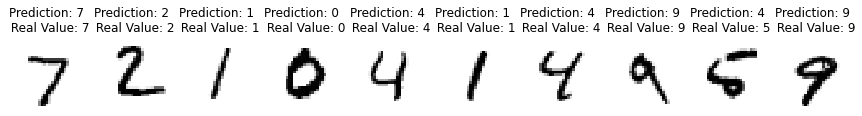

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, real_value, prediction in zip(axes, x_test, y_test, pred_test_model_600):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction} \n Real Value: {real_value}')

Se observa que la novena predicción se ha identificado erróneamente como 4.

Para un análisis mucho más detallado de los errores usamos las siguientes métricas:

### Matriz de confusión

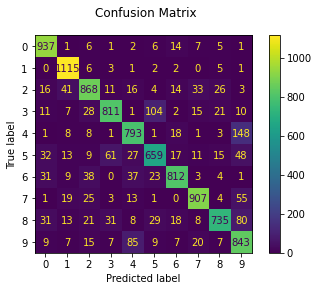

In [ ]:
from sklearn import metrics

disp = metrics.plot_confusion_matrix(rf_model_600_final, x_test, y_test, values_format = '')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

Como vemos, en general, nuestro modelo funciona correctamente para todas las clases. La diagonal concentra el mayor número de casos.

Además, se puede apreciar cómo en los números más diferentes entre sí, como el 0 y el 1. El algoritmo no confunde estas clases entre sí casi nunca (en total, solo ha clasificado erróneamente un 0 como un 1). Por contra, para los dígitos similares, como el 3 y el 5, o el 4 y el 9, hay un alto número de falsos positivos y negativos entre ellos.

### Precision, Recall y F1-score:

Para poder cuantificar mejor por clase los tipos de error que se están cometiendo, calculamos sus *recall*, *precision* y *f1-score*:

In [ ]:
print(f"Classification report for classifier {rf_model_600_final}:\n"
      f"{metrics.classification_report(y_test, pred_test_model_600)}\n")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.88      0.96      0.91       980
           1       0.90      0.98      0.94      1135
           2       0.85      0.84      0.84      1032
           3       0.87      0.80      0.84      1010
           4       0.81      0.81      0.81       982
           5       0.79      0.74      0.76       892
           6       0.90      0.85      0.87  

Como vemos, la clase que mejor se comporta se corresponde con el número 1, seguida del 0. Sobre todo, sobresale el valor *recall* de 0.98 obtenido para la cifra 1. Esto es esperable, ya que su forma es bastante diferente al resto de dígitos.

Por el contrario, los 5s y los 9s son los que peor F1-score tienen. En particular, la clase 9 tiene una precision muy baja, queriendo decir que muchas de las predicciones identificadas con 9 son en realidad falsos positivos.

## Modelo con max_depth bajo

Para ver qué efecto tendría haber usado árboles de decisión más sencillos en nuestro Random Forest, creamos de nuevo un modelo con max_depth = 5, un valor subóptimo. Un valor bajo, conlleva que los árboles de decisión no son los suficientemente complejos para realizar correctamente la clasificación, teniendo por tanto un modelo con *underfitting*.

In [ ]:
rf_model_600_5 = RandomForestClassifier(max_depth=5, random_state=0, n_jobs=5)
rf_model_600_5.fit(x_train_600,y_train_600)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Iteramos para diferentes números de árboles de decisión empleados, para ver si  en efecto cambia algo:

In [ ]:
n_estimators_list = []
score_train_list = []
score_test_list = []

for n_estimators in list(range(10,200,10)):
  rf_model = RandomForestClassifier(random_state=0, n_estimators = n_estimators, max_depth=5, n_jobs=5)
  rf_model.fit(x_train_600, y_train_600)

  ## Generación de listas
  n_estimators_list.append(n_estimators)
  score_train_list.append(100.0*rf_model.score(x_train_600, y_train_600))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

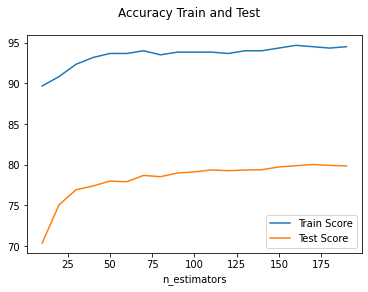

In [ ]:
df = pd.DataFrame({"n_estimators":n_estimators_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Se obtiene un resultado similar. En esta ocasión, el conjunto de pruebas no alcanza a superar el 80% de *accuracy*. Tal y como esperábamos, el resultado empeora comparado con max_depth = 10.

Por los argumentos vistos anteriormente, volvemos a escoger 75 estimadores como el valor compromiso entre tener un número reducido de árboles de decisión y un buen comportamiento sobre el conjunto de pruebas (menor *overfitting*).

In [ ]:
rf_model_600_suboptimo = RandomForestClassifier(max_depth=5, n_estimators = 75, random_state=0, n_jobs=5)
rf_model_600_suboptimo.fit(x_train_600,y_train_600)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred_train = rf_model_600_suboptimo.predict(x_train_600)
pred_test_model_600_sub = rf_model_600_suboptimo.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_600_suboptimo.score(x_train_600, y_train_600)))
accuracy_rf_model_600_suboptimo = 100.0*rf_model_600_suboptimo.score(x_test, y_test)
print("Precisión sobre los datos de test: {:.2f}".format(accuracy_rf_model_600_suboptimo))

Precisión sobre los datos de entrenamiento: 93.67
Precisión sobre los datos de test: 78.60


### Predicción
Se ve un ejemplo de las predicciones realizadas por este modelo: 

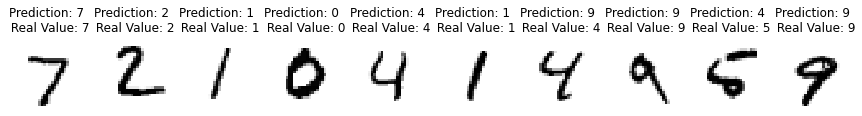

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, real_value, prediction in zip(axes, x_test, y_test, pred_test_model_600_sub):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction} \n Real Value: {real_value}')

En la séptima y en la novena predicción se ha identificado erróneamente un 4 como un 9 y un 5 como un 4, respectivamente.

A continuación, se aplican las diferentes métricas para analizar en detalle los errores:

### Matriz de confusión

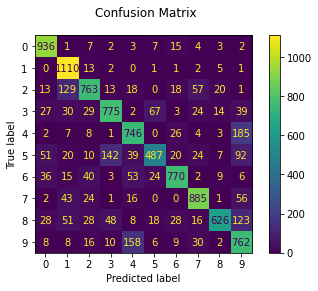

In [ ]:
disp = metrics.plot_confusion_matrix(rf_model_600_suboptimo, x_test, y_test, values_format = '')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

El modelo funciona bien para clases correspondientes a los dígitos 0 y 1. Sin embargo, no es capaz de leer los 5s adecuadamente. En concreto, este resultado es bastante peor que el obtenido con max_depth = 10. 

### Precision, Recall y F1-score:

Lo siguiente es calcular el *recall*, *precision* y *f1-score* de cada clase:

In [ ]:
print(f"Classification report for classifier {rf_model_600_suboptimo}:\n"
      f"{metrics.classification_report(y_test, pred_test_model_600_sub)}\n")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       980
           1       0.79      0.98      0.87      1135
           2       0.81      0.74      0.77      1032
           3       0.78      0.77      0.77      1010
           4       0.72      0.76      0.74       982
           5       0.80      0.55      0.65       892
           6       0.87      0.80      0.83   

En este caso, la clase que mejor *precision* tiene se corresponde con el número 6, con 0.87. No obstante, su *recall*  es relativamente malo, con solo un 0.8.

Por otro lado, el número que más *recall* tiene es el 1, con 0.98. Esta clase alcanza una *precision* de 0.79, un valor medio en comparación con el resto. 

A pesar de esto, la clase que tiene un f1-score más alto, el efecto combinado de *recall* y *precision*, es la 0, seguida de la 1. Esto tiene sentido, ya que ambas son bastante diferentes entre sí y del resto de clases, las cuales se parecen más entre ellas.

# **Modelos con n = 6000**

Repetimos el mismo procedimiento llevado a cabo anteriormente para el conjunto de datos n = 600:

* Escoger el mejor modelo

* Métricas sobre el algoritmo más óptimo.

## Elección del modelo

Primero, creamos diferentes algoritmos Random Forest cambiando los parámetros max_depth y n_estimators. Empezamos iterando con profundidades diferentes:

In [ ]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,30,4)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=maxdepth, n_jobs=5)
  rf_model.fit(x_train_6000, y_train_6000)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(x_train_6000, y_train_6000))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

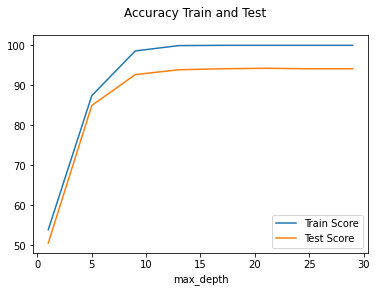

In [ ]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Se observa que, tanto para el conjunto de entrenamiento como para el de prueba, la *accuracy* va aumentando monótonamente conforme se incremeta el max_depth hasta llegar al valor k = 15, a partir del cual la tendencia es prácticamente constante.

Cuanto más sencillo sean nuestros árboles, menos recursos computacionales serán necesarios para entrenar o predecir. Por contra, sin son demasiado simples, presentarán *underfitting*. Teniendo esto en mente, escogemos como valor óptimo max_depth = 15, uno de los valores más pequeños donde la *accuracy* en el conjunto de prueba es más alta.

A continuación, iteramos sobre el número de estimadores:

In [ ]:
n_estimators_list = []
score_train_list = []
score_test_list = []

for n_estimators in list(range(10,200,10)):
  rf_model = RandomForestClassifier(random_state=0, n_estimators = n_estimators, max_depth=15, n_jobs=5)
  rf_model.fit(x_train_6000, y_train_6000)

  ## Generación de listas
  n_estimators_list.append(n_estimators)
  score_train_list.append(100.0*rf_model.score(x_train_6000, y_train_6000))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

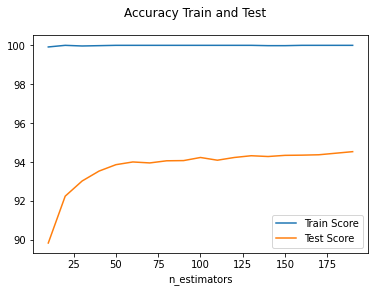

In [ ]:
df = pd.DataFrame({"n_estimators":n_estimators_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

De nuevo, para el conjunto de entrenamiento la *accuracy* se aproxima a 100 para cualquier valor del número de estimadores.

Por su lado, en el dataset de prueba la *accuracy* va aumentando de forma monótona hasta alcanzar el 94% en 100 estimadores, valor a partir del cual la tendencia se vuelve prácticamente constante. Como ya vimos, conforme el número de estimadores va aumentando el algoritmo se va haciendo más resistente al *overfitting*.

Escogemos el valor mínimo posible de forma que no afecte al rendimiento de nuestro modelo. Por tanto, un valor bueno se sitúa en 100 estimadores. 

## Modelo óptimo

Volvemos a repetir los mismos pasos:

* Crear el modelo que mejor se comporta en nuestro conjunto test teniendo en cuenta lo visto anteriormente.

* Aplicar las métricas correspondientes para analizar en profundidad su comportamiento.

In [ ]:
rf_model_6000_final = RandomForestClassifier(max_depth=15, n_estimators=100, random_state=0, n_jobs=5)
rf_model_6000_final.fit(x_train_6000,y_train_6000)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred_train_6000 = rf_model_6000_final.predict(x_train_6000)
pred_test_model_6000 = rf_model_6000_final.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_6000_final.score(x_train_6000, y_train_6000)))
accuracy_rf_model_6000_final = 100.0*rf_model_6000_final.score(x_test, y_test)
print("Precisión sobre los datos de test: {:.2f}".format(accuracy_rf_model_6000_final))

Precisión sobre los datos de entrenamiento: 100.00
Precisión sobre los datos de test: 94.23


### Predicción

Veamos un ejemplo de las predicciones realizadas por este modelo: 

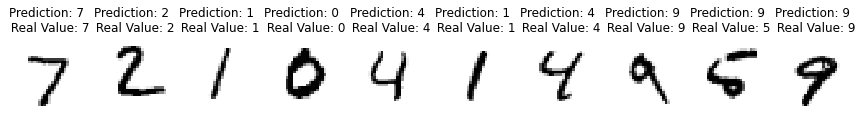

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, real_value, prediction in zip(axes, x_test, y_test, pred_test_model_6000):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction} \n Real Value: {real_value}')

Se vuelve a observar como la novena predicción, el 5, se ha identificado erróneamente como 9.

Usamos las siguientes métricas para un análisis mucho más detallado de los errores:

### Matriz de confusión


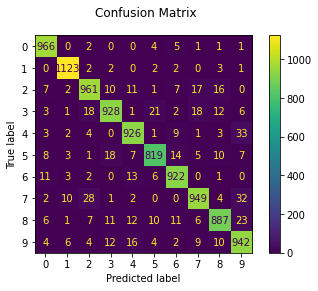

In [ ]:
disp = metrics.plot_confusion_matrix(rf_model_6000_final, x_test, y_test, values_format = '')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

En general, nuestro modelo funciona correctamente para todas las clases. La diagonal acumula la mayor parte de los casos.

A mayores, se aprecia cómo los números más diferentes entre sí, como el 0 y el 1, son perfectamente distinguibles por el algoritmo. No hay ningún 1 clasificado como 0, o viceversa. Por contra, para los dígitos similares, como el 3 y el 5, o el 4 y el 9, encontramos un número más alto de falsos positivos y negativos.

### Precision, Recall y F1-score:

A continuación, se cuantifica por clase los tipos de error, calculando el *recall*, *precision* y *f1-score*:

In [ ]:
print(f"Classification report for classifier {rf_model_6000_final}:\n"
      f"{metrics.classification_report(y_test, pred_test_model_6000)}\n")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.95      0.92      0.93      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.95      0.96      0.95 

Como vemos, las clases que mejor se comportan en general corresponden a los números 1 y 0. Ambas tienen un *recall* de 0.99, lo cual nos indica que casi todos los dígitos 0 y 1 han sido clasificados como tal. Además, la precision también es muy alta, de 0.96 para la clase 0 y de 0.98 para la clase 1, habiendo por tanto muy pocos falsos positivos.

Al contrario, los 8s y los 9s son los que peor F1-score tienen. En particular, la clase 9 tiene la *precision* más baja, indicando que muchas de las predicciones clasificadas como 9 son en realidad falsos positivos. El *recall* más bajo se encuentra en los 7s y en los 3s, siendo estos etiquetados erróneamente como otros números.

# **Conclusiones**

Se han realizado 3 modelos diferentes. En base a la *accuracy* se han obteniendo los siguientes resultados:

In [ ]:
data = {'Parámetros' : ['max_depth = 10, n_estimators = 75', 'max_depth = 5, n_estimators = 75', 'max_depth = 15, n_estimators = 100'], 
        'Accuracy': [accuracy_rf_model_600_final, accuracy_rf_model_600_suboptimo, accuracy_rf_model_6000_final]}  
pd.DataFrame(data, index=['Modelo óptimo n = 600', 
                    'Modelo subóptimo n = 600', 
                    'Modelo óptimo n = 6000'])

,Parámetros,Accuracy
Modelo óptimo n = 600,"max_depth = 10, n_estimators = 75",84.80
Modelo subóptimo n = 600,"max_depth = 5, n_estimators = 75",78.60
Modelo óptimo n = 6000,"max_depth = 15, n_estimators = 100",94.23


En general, los modelos n = 600 tienen un peor comportamiento que el modelo n = 6000. En concreto, el modelo subóptimo presenta el valor de *accuracy* más bajo. Por contra, en el modelo n = 6000 se aprecia una mejora muy significativa, un incremento casi del 10% con respecto al modelo óptimo n = 600.

Esto se ve reflejado en el resto de métricas, tanto las matrices de confusión como en el cálculo de los indicadores *precision*, *recall* y *f1-score*. Para verlo mejor, resumamos en una tabla los valores mínimos alcanzados en estos indicadores:

|    Modelo  |*Precision* mínima (%)| *Recall* mínimo (%)  | *F1-Score* mínimo (%)|
|---------------|:-------------:|:-------------:|:-------------:|
|   *óptimo n = 600*    |      71     |         74      |     76      |
|   *subóptimo n = 600*  |      60     |         55      |     65      |
|   *óptimo n = 6000*    |     90     |         91      |      92      |


Como se observa, el modelo n = 6000 es el único que funciona con al menos un 90% de *presicion* y *recall* en todas sus clases.

En todos estos modelos se concluyó que la clasificación es mejor para las clases 0 y 1, siendo el resto de números peor predichos. Dígitos como el 4, el 5 o el 8 son confundidos frecuentemente con el 9. De forma similar ocurre para el 2 y el 7. Esta evidencia soporta la hipótesis de que cifras con trazos más diferentes entre sí son mejor clasificados que aquellas cuya caligrafía es más parecida.

Por último, se ha analizado cómo influye cambiar el número de *n_estimators* (número de árboles de decisión) y *max_depth* (máxima profundidad de cada árbol) en los modelos. Aumentar el número de árboles protege del overfitting, a expensas de requerir un poder computacional más elevado. Por su lado, árboles con poca profundidad son más proclives a producir *underfitting*. Además, usar un mayor número de registros nos empuja a establecer un max_depth más elevado, obteniendo finalmente un modelo más complejo y con mejor comportamiento.